# Prediciting Churn rate for next 30 days

This notebook is implementing a predictive analysis model, that predicts the chrun rate for next 30 days based on Active and Inactive Customers.

## How This Model Enhances Customer Shopping Experience?

Using the churn predictions, Instacart could send targeted reminders or special offers to inactive customers. Offering discounts or exclusive deals to re-engage customers who haven't placed an order in a while.

In [28]:
import seaborn as sns
import numpy as np
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import mplcursors
import graphviz
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report
from google.cloud import bigquery
from pandas_gbq import read_gbq, to_gbq
from sklearn import preprocessing 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import export_text, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report, roc_auc_score,  mean_absolute_error, confusion_matrix
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.cluster import KMeans
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import os
from sklearn.metrics import confusion_matrix

In [12]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/Users/rishikeshdhokare/Documents/Ironhack/instacart-441209-84de4dcbf601.json"

# Create the connection to BigQuery
project_id = 'instacart-441209'
DATABASE_URI = f'bigquery://{project_id}'
engine = create_engine(DATABASE_URI)

/var/folders/43/30gtvzf54299gghzdyc8_l900000gn/T/ipykernel_21849/2034342299.py:6: SADeprecationWarning: The dbapi() classmethod on dialect classes has been renamed to import_dbapi().  Implement an import_dbapi() classmethod directly on class <class 'pybigquery.sqlalchemy_bigquery.BigQueryDialect'> to remove this warning; the old .dbapi() classmethod may be maintained for backwards compatibility.
  engine = create_engine(DATABASE_URI)


## What percentage of customers have churned in the last 30 days?

In [14]:
# Query to get the max days since prior order for each user
customer_activity_query = """
SELECT user_id, MAX(days_since_prior_order) AS max_days_since_prior
FROM `instacart-441209.instacart.orders`
GROUP BY user_id
"""

# Read data into DataFrame
customer_activity_df = pd.read_sql(customer_activity_query, engine)

inactive_customers = customer_activity_df[customer_activity_df['max_days_since_prior'] >= 30]
active_customers = customer_activity_df[customer_activity_df['max_days_since_prior'] < 30]

# Count of inactive and active customers
inactive_customers_30_days_count = inactive_customers['user_id'].nunique()
active_customers_30_days_count = active_customers['user_id'].nunique()

# Query to get total number of customers
total_customers_query = """
SELECT COUNT(DISTINCT user_id) AS total_customers
FROM `instacart-441209.instacart.orders`
"""

# Get the total number of unique customers
total_customers_df = pd.read_sql(total_customers_query, engine)
total_customers = total_customers_df['total_customers'][0]

# Calculate churn rate and active rate
churn_rate_30_days = (inactive_customers_30_days_count / total_customers) * 100
active_rate_30_days = (active_customers_30_days_count / total_customers) * 100

# Print results
print(f"Total number of unique customers: {total_customers}")
print(f"Number of active customers in the last 30 days: {active_customers_30_days_count}")
print(f"Number of inactive customers in the last 30 days: {inactive_customers_30_days_count}")
print(f"Churn rate for the last 30 days: {churn_rate_30_days:.2f}%")
print(f"Active rate for the last 30 days: {active_rate_30_days:.2f}%")

# Prepare results for CSV
results_df = pd.DataFrame({
    "Total_Customers": [total_customers],
    "Active_Customers_30_Days": [active_customers_30_days_count],
    "Inactive_Customers_30_Days": [inactive_customers_30_days_count],
    "Churn_Rate_30_Days": [churn_rate_30_days],
    "Active_Rate_30_Days": [active_rate_30_days]
})

# Save results to CSV
results_df.to_csv("/Users/rishikeshdhokare/Documents/Ironhack/FinalProject/csv/customer_churn_analysis.csv", index=False)
print("Results have been saved to customer_churn_analysis.csv")

Total number of unique customers: 206209
Number of active customers in the last 30 days: 54197
Number of inactive customers in the last 30 days: 152012
Churn rate for the last 30 days: 73.72%
Active rate for the last 30 days: 26.28%
Results have been saved to customer_churn_analysis.csv


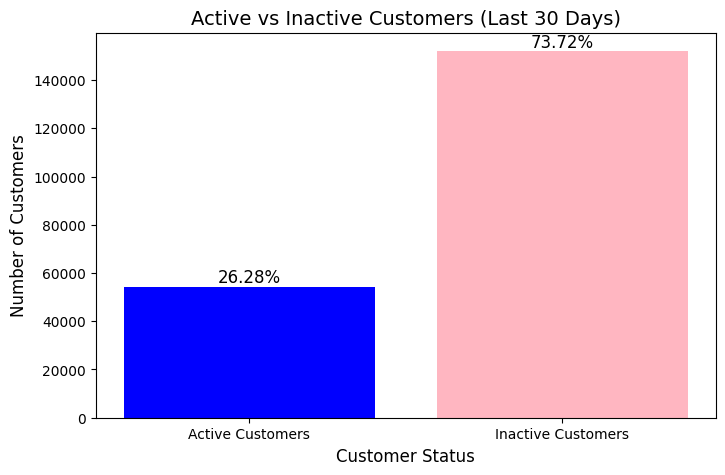

In [16]:
# Data for plotting
categories = ['Active Customers', 'Inactive Customers']
counts = [active_customers_30_days_count, inactive_customers_30_days_count]
percentages = [active_rate_30_days, churn_rate_30_days]

# Create the plot
plt.figure(figsize=(8, 5))
bars = plt.bar(categories, counts, color=['blue', 'lightpink'])
plt.title('Active vs Inactive Customers (Last 30 Days)', fontsize=14)
plt.xlabel('Customer Status', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
for i, bar in enumerate(bars):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 50, f'{percentages[i]:.2f}%', ha='center', va='bottom', fontsize=12)
plt.show()

# Future churn percentages

### Feature Engineering:
We calculate days_since_last_order, which represents how many days have passed since the customer's last order.
The churned column is created by checking if the days_since_last_order is greater than the churn_threshold (30 days).

In [106]:
query = """
SELECT
    op.order_id,
    op.product_id,
    op.add_to_cart_order,
    op.reordered,
    p.product_name,
    p.aisle_id,
    p.department_id,
    a.aisle,
    d.department,
    o.user_id,
    o.eval_set,
    o.order_number,
    o.order_dow,
    o.order_hour_of_day,
    o.days_since_prior_order
FROM
    `instacart-441209.instacart.order_products_train` AS op
JOIN
    `instacart-441209.instacart.products` AS p
    ON op.product_id = p.product_id
JOIN
    `instacart-441209.instacart.aisles` AS a
    ON p.aisle_id = a.aisle_id
JOIN
    `instacart-441209.instacart.departments` AS d
    ON p.department_id = d.department_id
JOIN
    `instacart-441209.instacart.orders` AS o
    ON op.order_id = o.order_id
LEFT JOIN
    `instacart-441209.instacart.order_products_prior` AS op_prior
    ON op_prior.order_id = op.order_id AND op_prior.product_id = op.product_id
"""

# Data into a DataFrame
combined_df = pd.read_sql(query, engine)
combined_df['days_since_prior_order'].fillna(0, inplace=True)

# Drop non-numeric columns and handle categorical features (encode them)
categorical_columns = ['product_name', 'eval_set']
for col in categorical_columns:
    le = LabelEncoder()
    combined_df[col] = le.fit_transform(combined_df[col])

# Encode 'aisle' and 'department' columns using get_dummies()
combined_df = pd.get_dummies(combined_df, columns=['aisle', 'department', 'eval_set'], drop_first=True)

churn_threshold = 30
combined_df['Churn'] = (combined_df['days_since_prior_order'] >= churn_threshold).astype(int)
combined_df['Churn'].fillna(0, inplace=True)
print(combined_df['Churn'].unique())


/var/folders/43/30gtvzf54299gghzdyc8_l900000gn/T/ipykernel_21849/1147900506.py:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_df['days_since_prior_order'].fillna(0, inplace=True)


[1 0]


/var/folders/43/30gtvzf54299gghzdyc8_l900000gn/T/ipykernel_21849/1147900506.py:52: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_df['Churn'].fillna(0, inplace=True)


## Correlation matrix

Correlation Matrix:
                          order_id  product_id  add_to_cart_order  reordered  \
order_id                  1.000000   -0.000545           0.001916   0.001418   
product_id               -0.000545    1.000000           0.003128   0.006560   
add_to_cart_order         0.001916    0.003128           1.000000  -0.146393   
reordered                 0.001418    0.006560          -0.146393   1.000000   
product_name             -0.000596    0.021362           0.017049  -0.000329   
...                            ...         ...                ...        ...   
department_personal care  0.002462   -0.012871           0.006220  -0.067111   
department_pets           0.000553   -0.007874          -0.006290   0.003680   
department_produce       -0.001792    0.067406          -0.028523   0.087221   
department_snacks         0.001704   -0.005789           0.033189  -0.010772   
Churn                    -0.001774    0.000467          -0.007771  -0.159577   

                   

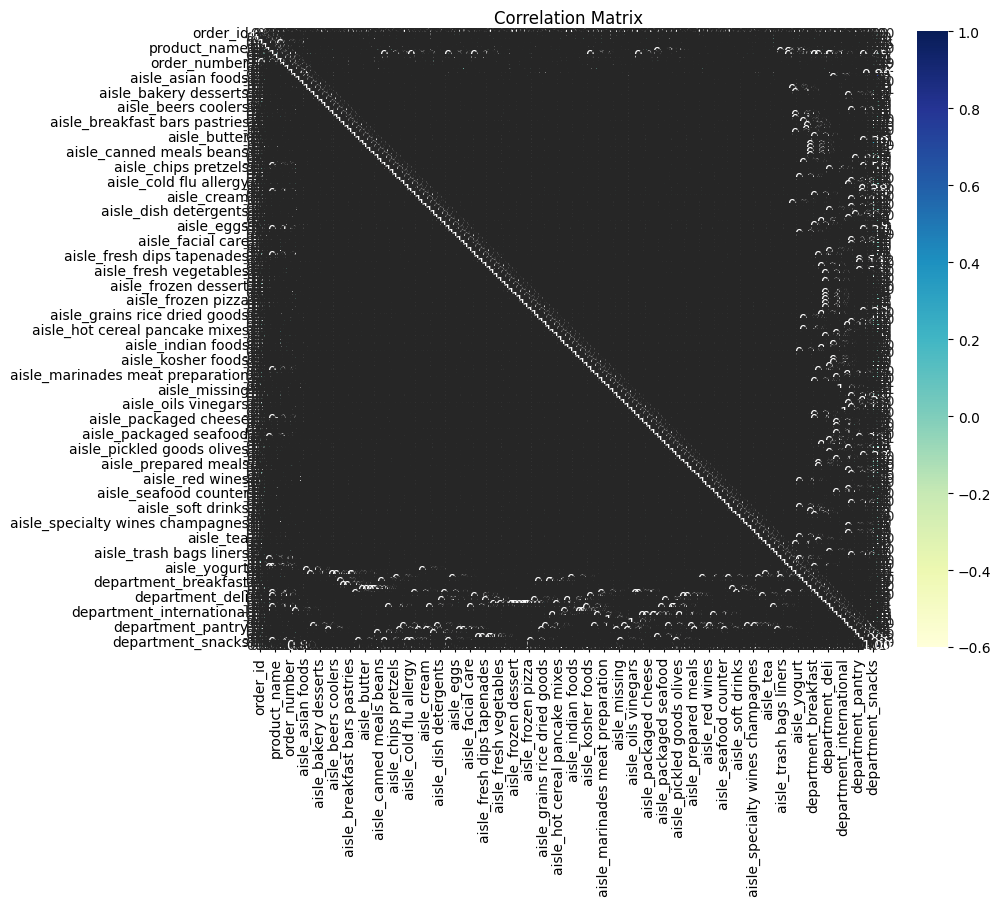

In [65]:
correlation_matrix = combined_df.corr()

# Display the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Plot the correlation matrix with a different color palette
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='YlGnBu', fmt='.2f', cbar=True, linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()


## Define feature and target

In [112]:
features = combined_df.drop(columns=['days_since_prior_order', 'product_name', 'Churn'])
target = combined_df['Churn']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

## Modeling

## XGBoost Classifier

Accuracy: 0.72
[[184782  10465]
 [ 66779  14898]]
              precision    recall  f1-score   support

           0       0.73      0.95      0.83    195247
           1       0.59      0.18      0.28     81677

    accuracy                           0.72    276924
   macro avg       0.66      0.56      0.55    276924
weighted avg       0.69      0.72      0.67    276924



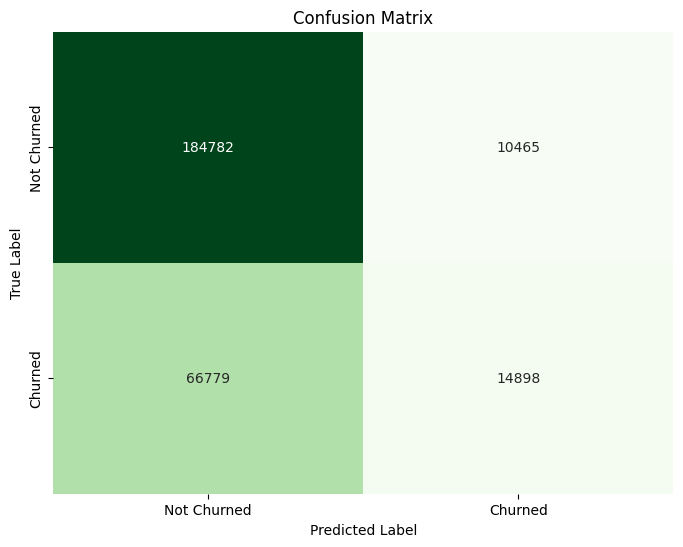

In [114]:
# Step 6: Initialize and train the XGBoost classifier (since churn is now a binary target)
model = xgb.XGBClassifier(objective="binary:logistic", n_estimators=100, max_depth=5)
model.fit(X_train, y_train)

# Step 7: Predict on the test set
y_pred = model.predict(X_test)

# Step 8: Evaluate the model
accuracy = (y_pred == y_test).mean()
print(f"Accuracy: {accuracy:.2f}")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Greens", cbar=False,
            xticklabels=["Not Churned", "Churned"], yticklabels=["Not Churned", "Churned"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [30]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_df = pd.DataFrame(conf_matrix, columns=["Predicted 0", "Predicted 1"], index=["Actual 0", "Actual 1"])
conf_matrix_df.to_csv('/Users/rishikeshdhokare/Documents/Ironhack/FinalProject/csv/confusion_matrix_churn_rate.csv')

### KNN Model

In [ ]:
normalizer = MinMaxScaler()
X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.transform(X_test)

# Set up K-Nearest Neighbors Classifier
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train_norm, y_train)

# Predict on the test set
y_pred = knn.predict(X_test_norm)

# Calculate accuracy
knn_accuracy = accuracy_score(y_test, y_pred)
print("KNN Model Accuracy:", knn_accuracy)

### Decision Tress

In [186]:
tree_clf = DecisionTreeClassifier(max_depth=10)
tree_clf.fit(X_train_norm, y_train)

pred = tree_clf.predict(X_test_norm)
print("MAE:", mean_absolute_error(pred, y_test))
print("RMSE:", mean_squared_error(pred, y_test, squared=False))
print("Accuracy:", tree_clf.score(X_test_norm, y_test))

MAE: 0.0
RMSE: 0.0
Accuracy: 1.0
Predicted churn rate for the next 30 days: 100.00%


/opt/anaconda3/envs/bigquery-env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Logistic Regression

In [255]:
og_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Predict classes on the test set
y_pred_class = log_reg.predict(X_test)

# Classification metrics
accuracy_log_reg = accuracy_score(y_test, y_pred_class)
conf_matrix_log_reg = confusion_matrix(y_test, y_pred_class)
class_report_log_reg = classification_report(y_test, y_pred_class)
roc_auc_log_reg = roc_auc_score(y_test, log_reg.predict_proba(X_test)[:, 1])

print("\nLogistic Regression Results:")
print(f'Accuracy: {accuracy_log_reg * 100:.2f}%')
print("Confusion Matrix:")
print(conf_matrix_log_reg)
print("Classification Report:")
print(class_report_log_reg)
print(f'ROC AUC Score: {roc_auc_log_reg:.2f}')


Logistic Regression Results:
Accuracy: 100.00%
Confusion Matrix:
[[16179     0]
 [    0 45684]]
Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     16179
        True       1.00      1.00      1.00     45684

    accuracy                           1.00     61863
   macro avg       1.00      1.00      1.00     61863
weighted avg       1.00      1.00      1.00     61863

ROC AUC Score: 1.00
Predicted churn rate for the next 30 days: 99.99%


/opt/anaconda3/envs/bigquery-env/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


### Random Forest Classifier

In [257]:
# Initialize and train Random Forest model
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)

# Predict churn on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Random Forest Model Accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

# Predict churn rate for the next 30 days based on Random Forest model
predicted_churn_prob = rf_model.predict_proba([[30, 1/30]])[0][1] * 100
print(f"Predicted churn rate for the next 30 days (Random Forest): {predicted_churn_prob:.2f}%")


Random Forest Model Accuracy: 100.00%
Confusion Matrix:
[[16179     0]
 [    0 45684]]
Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     16179
        True       1.00      1.00      1.00     45684

    accuracy                           1.00     61863
   macro avg       1.00      1.00      1.00     61863
weighted avg       1.00      1.00      1.00     61863

Predicted churn rate for the next 30 days (Random Forest): 100.00%


/opt/anaconda3/envs/bigquery-env/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


### Oversampling with SMOTE

In [259]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check the class distribution after resampling
print("Class distribution after SMOTE:", y_train_resampled.value_counts())

# Initialize and train the Random Forest model on the resampled data
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

# Predict churn on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Random Forest Model Accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

sample_input = [[30, 1/30]]
predicted_churn_prob = rf_model.predict_proba(sample_input)[0][1] * 100
print(f"Predicted churn rate for the next 30 days: {predicted_churn_prob:.2f}%")


Class distribution after SMOTE: is_churn
True     106328
False    106328
Name: count, dtype: int64
Random Forest Model Accuracy: 100.00%
Confusion Matrix:
[[16179     0]
 [    0 45684]]
Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     16179
        True       1.00      1.00      1.00     45684

    accuracy                           1.00     61863
   macro avg       1.00      1.00      1.00     61863
weighted avg       1.00      1.00      1.00     61863

Predicted churn rate for the next 30 days: 100.00%


/opt/anaconda3/envs/bigquery-env/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


### Undersampling

In [261]:
# Initialize RandomUnderSampler and apply it to the training set
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# Check the class distribution after undersampling
print("Class distribution after undersampling:", y_train_resampled.value_counts())

# Initialize and train Random Forest model on resampled data
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

# Predict churn on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Random Forest Model Accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

# Predict churn rate for the next 30 days based on Random Forest model
predicted_churn_prob = rf_model.predict_proba([[30, 1/30]])[0][1] * 100
print(f"Predicted churn rate for the next 30 days: {predicted_churn_prob:.2f}%")


Class distribution after undersampling: is_churn
False    38018
True     38018
Name: count, dtype: int64
Random Forest Model Accuracy: 100.00%
Confusion Matrix:
[[16179     0]
 [    0 45684]]
Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     16179
        True       1.00      1.00      1.00     45684

    accuracy                           1.00     61863
   macro avg       1.00      1.00      1.00     61863
weighted avg       1.00      1.00      1.00     61863

Predicted churn rate for the next 30 days: 100.00%


/opt/anaconda3/envs/bigquery-env/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


### Add Cluster-Based Features

In [263]:
customer_activity_df['is_churn'] = customer_activity_df['max_days_since_prior'] >= 30

# Select features for clustering and target variable
X_clustering = customer_activity_df[['max_days_since_prior', 'order_frequency']]
y = customer_activity_df['is_churn']

# Determine the number of clusters (e.g., 3 clusters)
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
customer_activity_df['cluster'] = kmeans.fit_predict(X_clustering)

# Add the new 'cluster' feature to your main dataset
X = customer_activity_df[['max_days_since_prior', 'order_frequency', 'cluster']]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)

# Predict churn on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Random Forest Model Accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

# Predict churn rate for the next 30 days based on Random Forest model
predicted_churn_prob = rf_model.predict_proba([[30, 1/30, 1]])[0][1] * 100
print(f"Predicted churn rate for the next 30 days (with clustering): {predicted_churn_prob:.2f}%")

Random Forest Model Accuracy: 100.00%
Confusion Matrix:
[[16179     0]
 [    0 45684]]
Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     16179
        True       1.00      1.00      1.00     45684

    accuracy                           1.00     61863
   macro avg       1.00      1.00      1.00     61863
weighted avg       1.00      1.00      1.00     61863

Predicted churn rate for the next 30 days (with clustering): 72.00%


/opt/anaconda3/envs/bigquery-env/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


### Gradient Boosting Classifier

In [271]:
gb_clf = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_clf.fit(X_train, y_train)

# Predict probabilities on the test set
y_pred_proba = gb_clf.predict_proba(X_test)[:, 1]  # Use probabilities for the positive class

# For regression metrics, use predicted probabilities instead of class predictions
mse_gb = mean_squared_error(y_test, y_pred_proba)  # Use probabilities for MSE
r2_gb = r2_score(y_test, y_pred_proba)  # Use probabilities for R^2
print("\nGradient Boosting Classifier Results:")
print(f'Mean Squared Error: {mse_gb:.2f}')
print(f'R^2 Score: {r2_gb:.2f}')

# Predicted churn probability for a specific input
input_features = [[30, 1/30, 1]] 
predicted_churn_prob = gb_clf.predict_proba(input_features)[0][1] * 100
print(f"Predicted churn rate for the next 30 days: {predicted_churn_prob:.2f}%")


Gradient Boosting Classifier Results:
Mean Squared Error: 0.00
R^2 Score: 1.00
Predicted churn rate for the next 30 days: 100.00%


/opt/anaconda3/envs/bigquery-env/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


### Ada Boost Regressor

In [275]:
# Base model
base_model = DecisionTreeRegressor(max_depth=3)  

# AdaBoost model
ada_model = AdaBoostRegressor(estimator=base_model, n_estimators=50, random_state=42)
ada_model.fit(X_train, y_train)

# Predictions on the test set
y_pred_ada = ada_model.predict(X_test)

# Calculate regression metrics
mse_ada = mean_squared_error(y_test, y_pred_ada)
r2_ada = r2_score(y_test, y_pred_ada)
print("\nAdaptive Boosting Results:")
print(f'Mean Squared Error: {mse_ada:.2f}')
print(f'R^2 Score: {r2_ada:.2f}')

# Predicted churn probability (just predicted value, not a probability)
predicted_churn_value = ada_model.predict([[30, 1/30, 1]])[0]  # Single prediction
print(f"Predicted churn value for the next 30 days: {predicted_churn_value:.2f}")


Adaptive Boosting Results:
Mean Squared Error: 0.00
R^2 Score: 1.00
Predicted churn value for the next 30 days: 1.00


/opt/anaconda3/envs/bigquery-env/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(


In [277]:
# Make predictions for the next 30 days
predicted_churn_df = customer_activity_df.copy()
predicted_churn_df['churn_prediction'] = model.predict(features)

# Calculate predicted churn rate
predicted_churn_customers = predicted_churn_df[predicted_churn_df['churn_prediction'] == 1]
predicted_churn_rate = (predicted_churn_customers['user_id'].nunique() / total_customers) * 100

# Print the predicted churn rate for the next 30 days
print("\nPredicted Churn rate for next 30 days:", predicted_churn_rate)


Predicted Churn rate for next 30 days: 73.71744201271525
